# Jan 25 Analysis#
Ivan Arias

2020/07/09

In [3]:
import pyart
import time

import Jan25_utl as utl
import importlib

from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import netCDF4

import scipy.ndimage as spyi

In [4]:
# Create grid

importlib.reload(utl)

# CHIVO level 1b
chivo_filename = '/net/denali/storage/radar/RELAMPAGO/quality_controlled_data/level_1b_2/2019/01/25/chivo.1b.20190125_210047.REL_PNL135A.nc'

chivo = pyart.io.read(chivo_filename)
chivo_grid = utl.grid_radar(chivo, origin=(chivo.latitude['data'][0], chivo.longitude['data'][0]))

time_start = netCDF4.num2date(chivo_grid.time['data'][0], chivo_grid.time['units'])
time_text = time_start.strftime('%Y%m%dT%H%M')

chivo_grid_fname = ('chivo_grid_'+ time_text + '.nc')
chivo_grid.write(chivo_grid_fname)

/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


In [20]:
# Read topography

topo_filename = '/net/nasstore/students/GRAD/ECE/idariash/home/CSU/RELAMPAGO/analysis/Mountain/terr.nc'
topography = Dataset(topo_filename)

lons = topography.variables['X'][:]
lats = topography.variables['Y'][:]
terr = topography.variables['topo'][:]

/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: The following kwargs were not used by contour: 'animated'
/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:189: UserWarning: The following kwargs were not used by contour: 'animated'


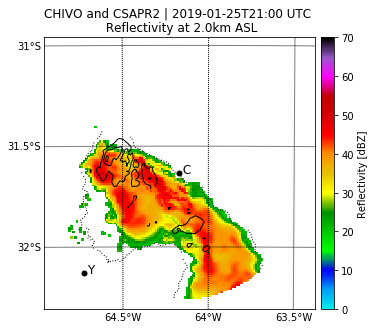

In [135]:
# Plot PPI over map

filename = '/net/nasstore/students/GRAD/ECE/idariash/home/CSU/CHIVO/MultiDop/examples/cf_compliant_grid_20190125_2100.nc'
#'chivo_grid_20190125T2100.nc'
ilev = 2
height_toCut = 1.0
reflectivity_toCut = 20
range_toCut = 70
maxHeight_toCut = 4

chivo_grid = pyart.io.read_grid(filename)

lon_0 = chivo_grid.origin_longitude['data']
lat_0 = chivo_grid.origin_latitude['data']

delta = 4#deg
lats_mask = np.absolute(lats - lat_0) < delta

#(lat_0 - delta < lats) & (lats < lat_0 + 1)
lons_mask = np.absolute(lons - lon_0) < delta
#(lon_0 - delta < lons) & (lons < lon_0 + 1)  

Sierras_terr = terr[lats_mask, :]
Sierras_terr = Sierras_terr[:, lons_mask]
Sierras_terr = np.ma.masked_where( Sierras_terr < 500, Sierras_terr)

Sierras_lons = lons[lons_mask]
Sierras_lats = lats[lats_mask]

Sierras_lons_grid, Sierras_lats_grid = np.meshgrid(Sierras_lons, Sierras_lats)

Sierras_terr = spyi.gaussian_filter(Sierras_terr, sigma = 2)



fig = plt.figure(figsize=(6, 5))



m = Basemap(projection='lcc', resolution=None,
            width=150E3, height=150E3, 
            lat_0=lat_0, lon_0=lon_0)

#m.etopo(scale=2, alpha=0.5)

parallels = np.arange(-40,-20,0.5)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False, False])

meridians = np.arange(-70,-60.,0.5)
m.drawmeridians(meridians,labels=[True,False,False,True])

x_Cordoba, y_Cordoba = m(-64.19, -31.42)
x_CHIVO, y_CHIVO = m(-64.1686, -31.6342)
x_ARM, y_ARM = m(-64.7284, -32.1264)
x_Rio4to, y_Rio4to = m(-64.3493, -33.1232)

plt.plot(x_CHIVO, y_CHIVO, 'ok', markersize=5)
plt.text(x_CHIVO, y_CHIVO, ' C', fontsize=12);
                                       
plt.plot(x_ARM, y_ARM, 'ok', markersize=5)
plt.text(x_ARM, y_ARM, ' Y', fontsize=12);
                                       
levels_terr = [500, 1500]

# terr_contour = m.contour(Sierras_lons_grid, Sierras_lats_grid, Sierras_terr, levels_terr, 
#                latlon = True, linewidths = 1, colors = 'k',
#                       linestyles='solid', antialiased=True, animated=True)

# plt.clabel(terr_contour, levels_terr, fmt='%r', inline=True, fontsize = 10)

#------------------

Z = chivo_grid.fields['reflectivity']['data']
x, y, z = np.meshgrid(0.001*chivo_grid.x['data'], 0.001*chivo_grid.y['data'],
                     0.001*chivo_grid.z['data'])

x = np.swapaxes(x,1,2)
x = np.swapaxes(x,0,1)

y = np.swapaxes(y,1,2)
y = np.swapaxes(y,0,1)

z = np.swapaxes(z,1,2)
z = np.swapaxes(z,0,1)

R = np.sqrt(x ** 2 + y ** 2 + z ** 2)

Z = np.ma.masked_where( R > range_toCut, Z)

Z_max = np.amax(Z, axis=0)
Z_max = np.ma.masked_where( Z_max < 18, Z_max)

#Z_max = spyi.gaussian_filter(Z_max, sigma = 1)

levels_Z = [20]

m.contour(chivo_lons, chivo_lats, Z_max, levels_Z, 
               latlon = True, linewidths = 1, colors = 'k',
                      linestyles='dotted', antialiased=True, animated=True)

#--------------------------------


Z = chivo_grid.fields['reflectivity']['data']

x, y, z = np.meshgrid(0.001*chivo_grid.x['data'], 0.001*chivo_grid.y['data'],
                     0.001*chivo_grid.z['data'])

x = np.swapaxes(x,1,2)
x = np.swapaxes(x,0,1)

y = np.swapaxes(y,1,2)
y = np.swapaxes(y,0,1)

z = np.swapaxes(z,1,2)
z = np.swapaxes(z,0,1)

R = np.sqrt(x ** 2 + y ** 2 + z ** 2)

Z = np.ma.masked_where( z > maxHeight_toCut, Z)
# delta = 0.6
# height_mask = np.absolute(z - 2) < delta
#Z = np.ma.masked_where( height_mask, Z)

Z = np.ma.masked_where( R > range_toCut, Z)
Z = np.ma.masked_where( Z < reflectivity_toCut, Z)

Z_max = np.amax(Z, axis=0)
Z_mean = np.mean(Z, axis=0)

chivo_lons, chivo_lats = chivo_grid.get_point_longitude_latitude()

cs = m.pcolormesh(chivo_lons, chivo_lats, Z_mean, vmin=0, vmax=70, latlon=True,
             cmap='pyart_NWSRef')

m.colorbar(cs, label='Reflectivity [dBZ]')

time_start = netCDF4.num2date(chivo_grid.time['data'][0], chivo_grid.time['units'])
time_text = time_start.strftime('%Y-%m-%dT%H:%M UTC')


plt.title('CHIVO and CSAPR2 | '+ time_text+ ' \n Reflectivity at ' + str(1+ ilev/2) + 'km ASL')

time_text = time_start.strftime('%Y%m%dT%H%M')
fig_name = ('./fig/sur_maxRef_' + time_text + '.png')
fig.savefig(fig_name)

#---------------------

Z = chivo_grid.fields['reflectivity']['data']

U = chivo_grid.fields['eastward_wind']['data']
V = chivo_grid.fields['northward_wind']['data']
W = chivo_grid.fields['upward_air_velocity']['data']

U = np.ma.masked_where( R > range_toCut, U)
V = np.ma.masked_where( R > range_toCut, V)
W = np.ma.masked_where( R > range_toCut, W)

# U = np.ma.masked_where( Z < 20, U)
# V = np.ma.masked_where( Z < 20, V)

x, y, z = np.meshgrid(0.001*chivo_grid.x['data'], 0.001*chivo_grid.y['data'],
                     0.001*chivo_grid.z['data'])

x = np.swapaxes(x,1,2)
x = np.swapaxes(x,0,1)

y = np.swapaxes(y,1,2)
y = np.swapaxes(y,0,1)

z = np.swapaxes(z,1,2)
z = np.swapaxes(z,0,1)

R = np.sqrt(x ** 2 + y ** 2 + z ** 2)

W = np.ma.masked_where( Z < 0, W)
W = np.ma.masked_where( z < maxHeight_toCut, W)

W_max = np.amax(W, axis=0)

#W_max = spyi.gaussian_filter(W_max, sigma = 0.5)

levels_W = [20, 40, 60]

m.contour(chivo_lons, chivo_lats, W_max, levels_W, 
               latlon = True, linewidths = 1, colors = 'k',
                      linestyles='solid', antialiased=True, animated=True)



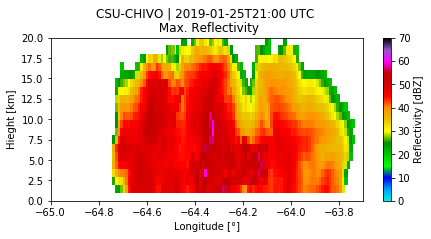

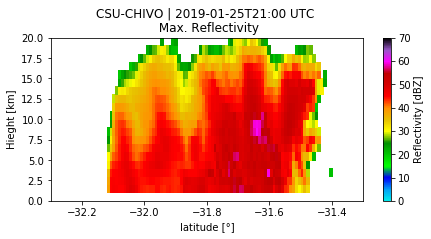

In [57]:
#---------------------------------------------------------

Z = chivo_grid.fields['reflectivity']['data']

Z = np.ma.masked_where( Z < reflectivity_toCut, Z)

x, y, z = np.meshgrid(0.001*chivo_grid.x['data'], 0.001*chivo_grid.y['data'],
                     0.001*chivo_grid.z['data'])

x = np.swapaxes(x,1,2)
x = np.swapaxes(x,0,1)

y = np.swapaxes(y,1,2)
y = np.swapaxes(y,0,1)

z = np.swapaxes(z,1,2)
z = np.swapaxes(z,0,1)

R = np.sqrt(x ** 2 + y ** 2 + z ** 2)

Z = np.ma.masked_where( z < height_toCut, Z)
Z = np.ma.masked_where( R > range_toCut, Z)


#Zdr_max = np.ma.masked_where( Z_max < 20, Zdr_max)

lon_0 = chivo_grid.origin_longitude['data']
lat_0 = chivo_grid.origin_latitude['data']
chivo_lons, chivo_lats = chivo_grid.get_point_longitude_latitude()

x, z = np.meshgrid(0.001*chivo_grid.x['data'], 0.001*chivo_grid.z['data'])

Z = np.swapaxes(Z,0,1)

Z_max = np.amax(Z, axis=0)
lons_vector = np.mean(chivo_lons, axis=0)
lons_mat, z = np.meshgrid(lons_vector, 0.001*chivo_grid.z['data'])

fig = plt.figure(figsize=(7, 3))
cs = plt.pcolormesh(lons_mat, z, Z_max, vmin=0, vmax=70,# latlon=True,
             cmap='pyart_NWSRef')

plt.colorbar(cs, label='Reflectivity [dBZ]')

time_start = netCDF4.num2date(chivo_grid.time['data'][0], chivo_grid.time['units'])
time_text = time_start.strftime('%Y-%m-%dT%H:%M UTC')

plt.title('CSU-CHIVO | '+ time_text+ ' \n Max. Reflectivity')

plt.xlim(-65, -63.7)
plt.ylim(0, 20)

plt.xlabel('Longitude [°]')
plt.ylabel('Hieght [km]')

time_text = time_start.strftime('%Y%m%dT%H%M')
fig_name = ('./fig/lon_maxRef_' + time_text + '.png')
fig.savefig(fig_name)

#---------------------------------------------------
Z = chivo_grid.fields['reflectivity']['data']

Z = np.ma.masked_where( Z < reflectivity_toCut, Z)

x, y, z = np.meshgrid(0.001*chivo_grid.x['data'], 0.001*chivo_grid.y['data'],
                     0.001*chivo_grid.z['data'])

x = np.swapaxes(x,1,2)
x = np.swapaxes(x,0,1)

y = np.swapaxes(y,1,2)
y = np.swapaxes(y,0,1)

z = np.swapaxes(z,1,2)
z = np.swapaxes(z,0,1)

R = np.sqrt(x ** 2 + y ** 2 + z ** 2)

Z = np.ma.masked_where( z < height_toCut, Z)
Z = np.ma.masked_where( R > range_toCut, Z)


#Zdr_max = np.ma.masked_where( Z_max < 20, Zdr_max)

lon_0 = chivo_grid.origin_longitude['data']
lat_0 = chivo_grid.origin_latitude['data']
chivo_lons, chivo_lats = chivo_grid.get_point_longitude_latitude()

x, z = np.meshgrid(0.001*chivo_grid.x['data'], 0.001*chivo_grid.z['data'])

Z = np.swapaxes(Z,1,2) # comment for x
Z = np.swapaxes(Z,0,1)

Z_max = np.amax(Z, axis=0)
lats_vector = np.mean(chivo_lats, axis=1)
lats_mat, z = np.meshgrid(lats_vector, 0.001*chivo_grid.z['data'])

fig = plt.figure(figsize=(7, 3))
cs = plt.pcolormesh(lats_mat, z, Z_max, vmin=0, vmax=70,# latlon=True,
             cmap='pyart_NWSRef')

plt.colorbar(cs, label='Reflectivity [dBZ]')

time_start = netCDF4.num2date(chivo_grid.time['data'][0], chivo_grid.time['units'])
time_text = time_start.strftime('%Y-%m-%dT%H:%M UTC')

plt.title('CSU-CHIVO | '+ time_text+ ' \n Max. Reflectivity')

plt.xlim(-32.3, -31.3)
plt.ylim(0, 20)

plt.xlabel('latitude [°]')
plt.ylabel('Hieght [km]')

time_text = time_start.strftime('%Y%m%dT%H%M')
fig_name = ('./fig/lon_maxRef_' + time_text + '.png')
fig.savefig(fig_name)